In [1]:
import sys
sys.path.insert(0, '../../../')

# Base packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
from scipy import ndimage as ndi
import matplotlib.colors
import cv2

# Included in anaconda
import glob
import os

# External packages
from moviepy.editor import *
import hyperspy.api as hs
from tqdm import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline
import pywt

import tensorflow as tf
import tensorflow.keras as keras
from temnn.knet import MSDnet, Unet
from temnn.data.mods import local_normalize

from stm.feature.peaks import find_local_peaks

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 22})

# Functions

We will be working with hyperspy objects to make use of their many functionalities.

In [2]:
def to_hs(im_array,im_ref):
    '''
    Function to convert a numpy array (im_array) into a hyperspy object 
    and set scale equal to that of a previously defined hyperspy object (im_ref)
    
    Returns a calibrated hyperspy object im_cal
    '''
    im_cal=hs.signals.Signal2D(im_array)
    
    im_cal.axes_manager.signal_axes[0].scale=im_ref.axes_manager.signal_axes[0].scale
    im_cal.axes_manager.signal_axes[1].scale=im_ref.axes_manager.signal_axes[1].scale

    im_cal.axes_manager.signal_axes[0].units=im_ref.axes_manager.signal_axes[0].units
    im_cal.axes_manager.signal_axes[1].units=im_ref.axes_manager.signal_axes[1].units
    
    return im_cal

We will likely be calculating the dose a few times I've put it into a function, docstring below should explain it

In [3]:
def compute_dose_rate(
    intensity,brightness,
    area,exposure):
    '''
    Function to compute dose given intensity integrated over an area
    Brightness calibration and exposure time required
    
    Return dose in units of electrons per angstrom^2 per second
    '''
    dose_rate=(intensity*brightness_cal)/(area*exposure)/100
    
    return dose_rate

In [4]:
def expand_mask(mask, radius=10):
    expand = mask.copy()
    for j in range(radius,mask.shape[1]):
        for k in range(radius,mask.shape[2]):
            window = mask[0,j-radius:j+radius,k-radius:k+radius]
            fraction = np.count_nonzero(window == 1.0)/(window.shape[0]*window.shape[1])
            if fraction > 0.1:
                expand[0,j,k] = 1.0
    return expand

def crop_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,0].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def crop_substrate(img, infer):
    # Make the inference mask binary
    binary = infer[:,:,:,1].copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary)
    blur_level=200
    crop = cv2.blur(crop[0,:,:], (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def cover_nanoparticle(img, infer):
    # Make the inference mask binary
    binary = infer.copy()
    binary[binary > 0.01] = 1.0
    
    # Expand the inference mask
    crop = expand_mask(binary,radius=100)
    crop = skimage.util.invert(crop[0,:,:,0])
    blur_level=200
    crop = cv2.blur(crop, (blur_level, blur_level))
    crop = crop.reshape((1,)+crop.shape+(1,))
    
    # Crop out nanoparticle
    img_crop = img*crop
    return img_crop, crop

def trim_imagescale(img, percent=1):
    sorted_pixels = sorted(img.flatten())
    n = len(sorted_pixels)
    trim = int(n*percent/100)
    return sorted_pixels[trim: n-trim]

def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    cf = f.shape[0]/2,f.shape[1]/2
    f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.abs(f) #np.log(1+np.abs(f)) #np.abs(f)

In [5]:
def block_centre(img):
    center = img.shape[0]/2,img.shape[1]/2
    img[int(center[0]-10):int(center[0]+10),int(center[1]-10):int(center[1]+10)] = 0.0
    return img

def rot_mat(theta):
    r = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta)) ))
    return r

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2*np.pi
    return rho, phi

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

I have trained Neural networks to do both multiclass and single class segmentation, so for plotting purposes toggle the boolean below.

In [6]:
multiclass = False

# Load data

In [7]:
folder='../../experimental_data/WilliamBang/20201201_ETEM_MEMS6/ROI1'
doserate='DR2_AuNP1_ADC'
files=glob.glob(r'{}/{}/Hour_00/Minute_*/Second_*/*.dm4'.format(folder,doserate))
# We can output the filenames gathered by glob to make sure they are correct
#files

In [8]:
if multiclass:
    output_dir='{}/nanoparticle_multiclass_processing_output'.format(folder)
else:
    output_dir='{}/nanoparticle_singleclass_processing_output'.format(folder)
# Check if an output folder exists first, if not then creates one (will only create one the first time for a new dataset)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [9]:
if not os.path.exists('{}/stack_{}.hspy'.format(output_dir,doserate)):
    i=hs.load(files,lazy=True,stack=True)

In [10]:
if not os.path.exists('{}/stack_{}.hspy'.format(output_dir,doserate)):
    # Saving the whole stack as a hyperspy object in this new output folder (you could do this as a tif or hdf5)
    # This is smaller than the combination of all the dm4 files
    i.save('{}/stack_{}.hspy'.format(output_dir,doserate),overwrite=True)

In [11]:
# Now I can load the hyperspy file rather than use the lazy-loaded individual files
i=hs.load('{}/stack_{}.hspy'.format(output_dir,doserate),lazy=False)

In [12]:
# This is because we loaded the data as a stack. The stack metadata has each individual frame's metadata
# The original data is in a 'DictionaryTree' but we want to loop through it
# So I am converting it to a standard Python dictionary
stack_metadata=i.original_metadata.stack_elements.as_dictionary()

# An individual frame's metadata is then:
frame_index=0
frame_metadata=stack_metadata['element{}'.format(frame_index)]

In [13]:
i.axes_manager.navigation_axes[0].scale=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']
i.axes_manager.navigation_axes[0].units='s'
i.axes_manager.navigation_axes[0].name='t'
i.axes_manager

<Axes manager, axes: (185|857, 794)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               t |    185 |      0 |       0 |     0.2 |      s 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |    857 |        |      -0 |  0.0073 |     nm 
               y |    794 |        |      -0 |  0.0073 |     nm

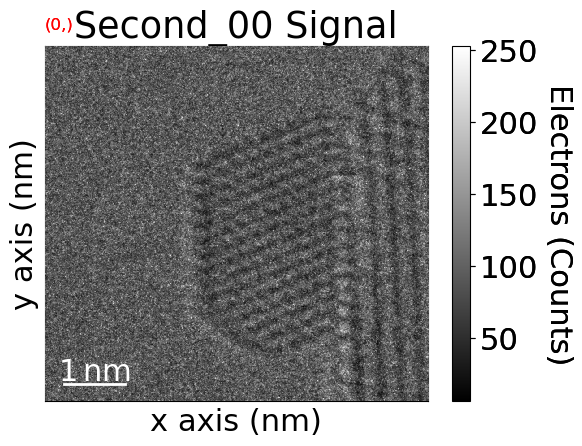

In [14]:
i.plot(navigator='slider')
plt.show()

In [15]:
x_cal,y_cal=i.axes_manager.signal_axes[0].scale,i.axes_manager.signal_axes[1].scale
x_size,y_size=i.axes_manager.signal_axes[0].size,i.axes_manager.signal_axes[1].size

x_nm,y_nm=x_cal*x_size,y_cal*y_size

# Calculate dose rates

In [16]:
im=to_hs(i.data,i)

In [17]:
brightness_cal=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageData']['Calibrations']['Brightness']['Scale']
exposure=frame_metadata['original_metadata']['ImageList']['TagGroup0']['ImageTags']['DataBar']['Exposure Time (s)']

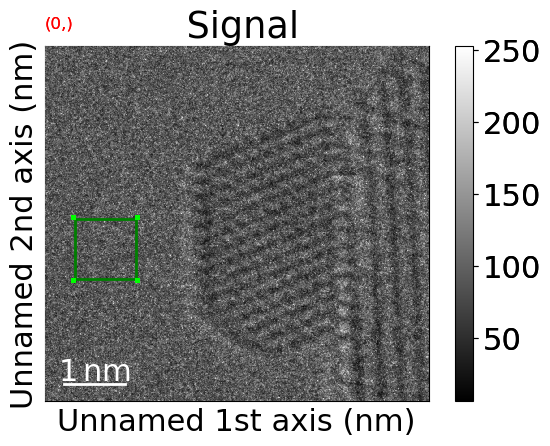

In [18]:
# You can play around with these values and shift it wherever you want, you can even drag it around on the plot
rect=hs.roi.RectangularROI(left=0.5,right=1.5,top=y_nm-3, bottom=y_nm-2)
im.plot(navigator='slider')
roi=rect.interactive(im)
plt.show()

In [19]:
roi_data=roi.data
dose_rate_list=[]
area=roi.inav[0].data.shape[0]*roi.inav[0].data.shape[1]*(x_cal*y_cal)

for n in tqdm(range(0,roi_data.shape[0])):
    dose_rate_list.append(compute_dose_rate(roi_data[n].sum(),brightness_cal,area,exposure))
dose_rates=np.array(dose_rate_list)

100%|██████████| 185/185 [00:00<00:00, 19470.70it/s]


In [20]:
doses=dose_rates*exposure

# Analysis

Below I will work with a random example specified by 'frame_index' to test the result and formatting before running the loop over all frames

In [21]:
frame_dose_rate=dose_rates[frame_index]
frame_dose=doses[frame_index]
frame_cumulative_dose=np.sum(doses[0:frame_index+1])
frame_time=np.round(exposure*(frame_index+1),2)

assert x_cal == y_cal

normalizerange = 12.0/(x_cal*10)

img = local_normalize(im.data[frame_index], normalizerange, normalizerange)
img.shape = (1,) + img.shape + (1,)

# Scale image distribution

To avoid dead/burning pixels shifting the contrast of the images displayed later I will scale every image remove the upper and lower 1% of the pixel value distribution. Here I visualise the cut.

In [22]:
trimmed_pixels = trim_imagescale(img)            # Trim away the upper and lower 1% (default)
scale = min(trimmed_pixels), max(trimmed_pixels) # Save the values to scale

# Wavelet Analysis

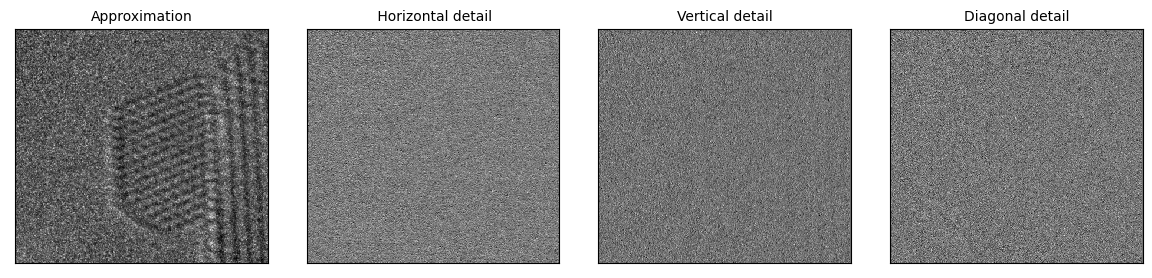

In [23]:
import pywt.data
# Load image
#original = pywt.data.camera()
original = img[0,:,:,0]

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'db1')

LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

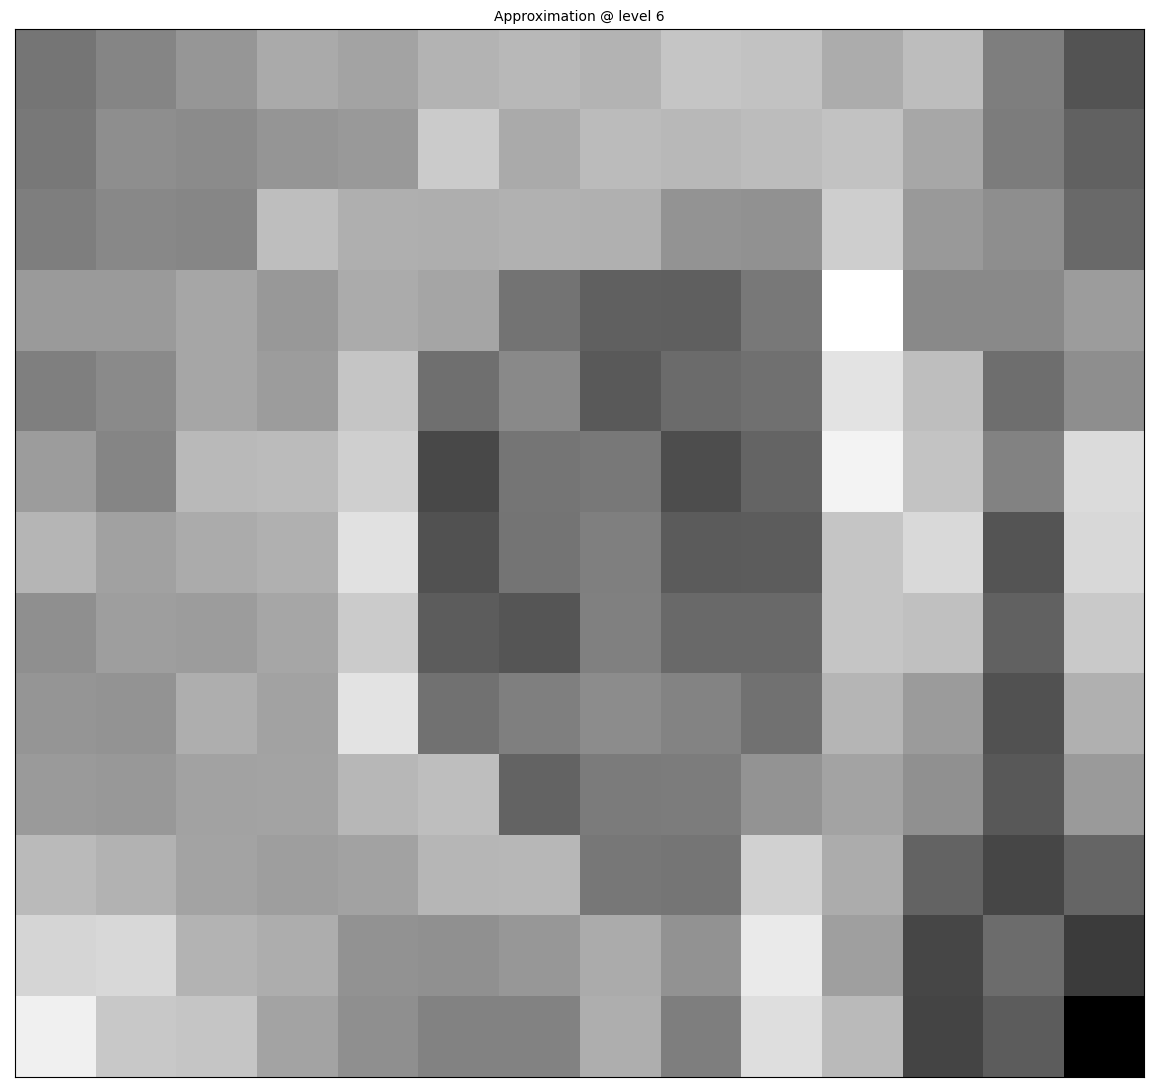

In [24]:
levels=6

C = pywt.wavedec2(original, 'db1', mode='periodization',level=levels)

titles = ['Approximation @ level {}'.format(levels), ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

cA2=C[0]
fig = plt.figure(figsize=(12, 12))
plt.imshow(cA2, interpolation="nearest", cmap=plt.cm.gray)
plt.title(titles[0], fontsize=10)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

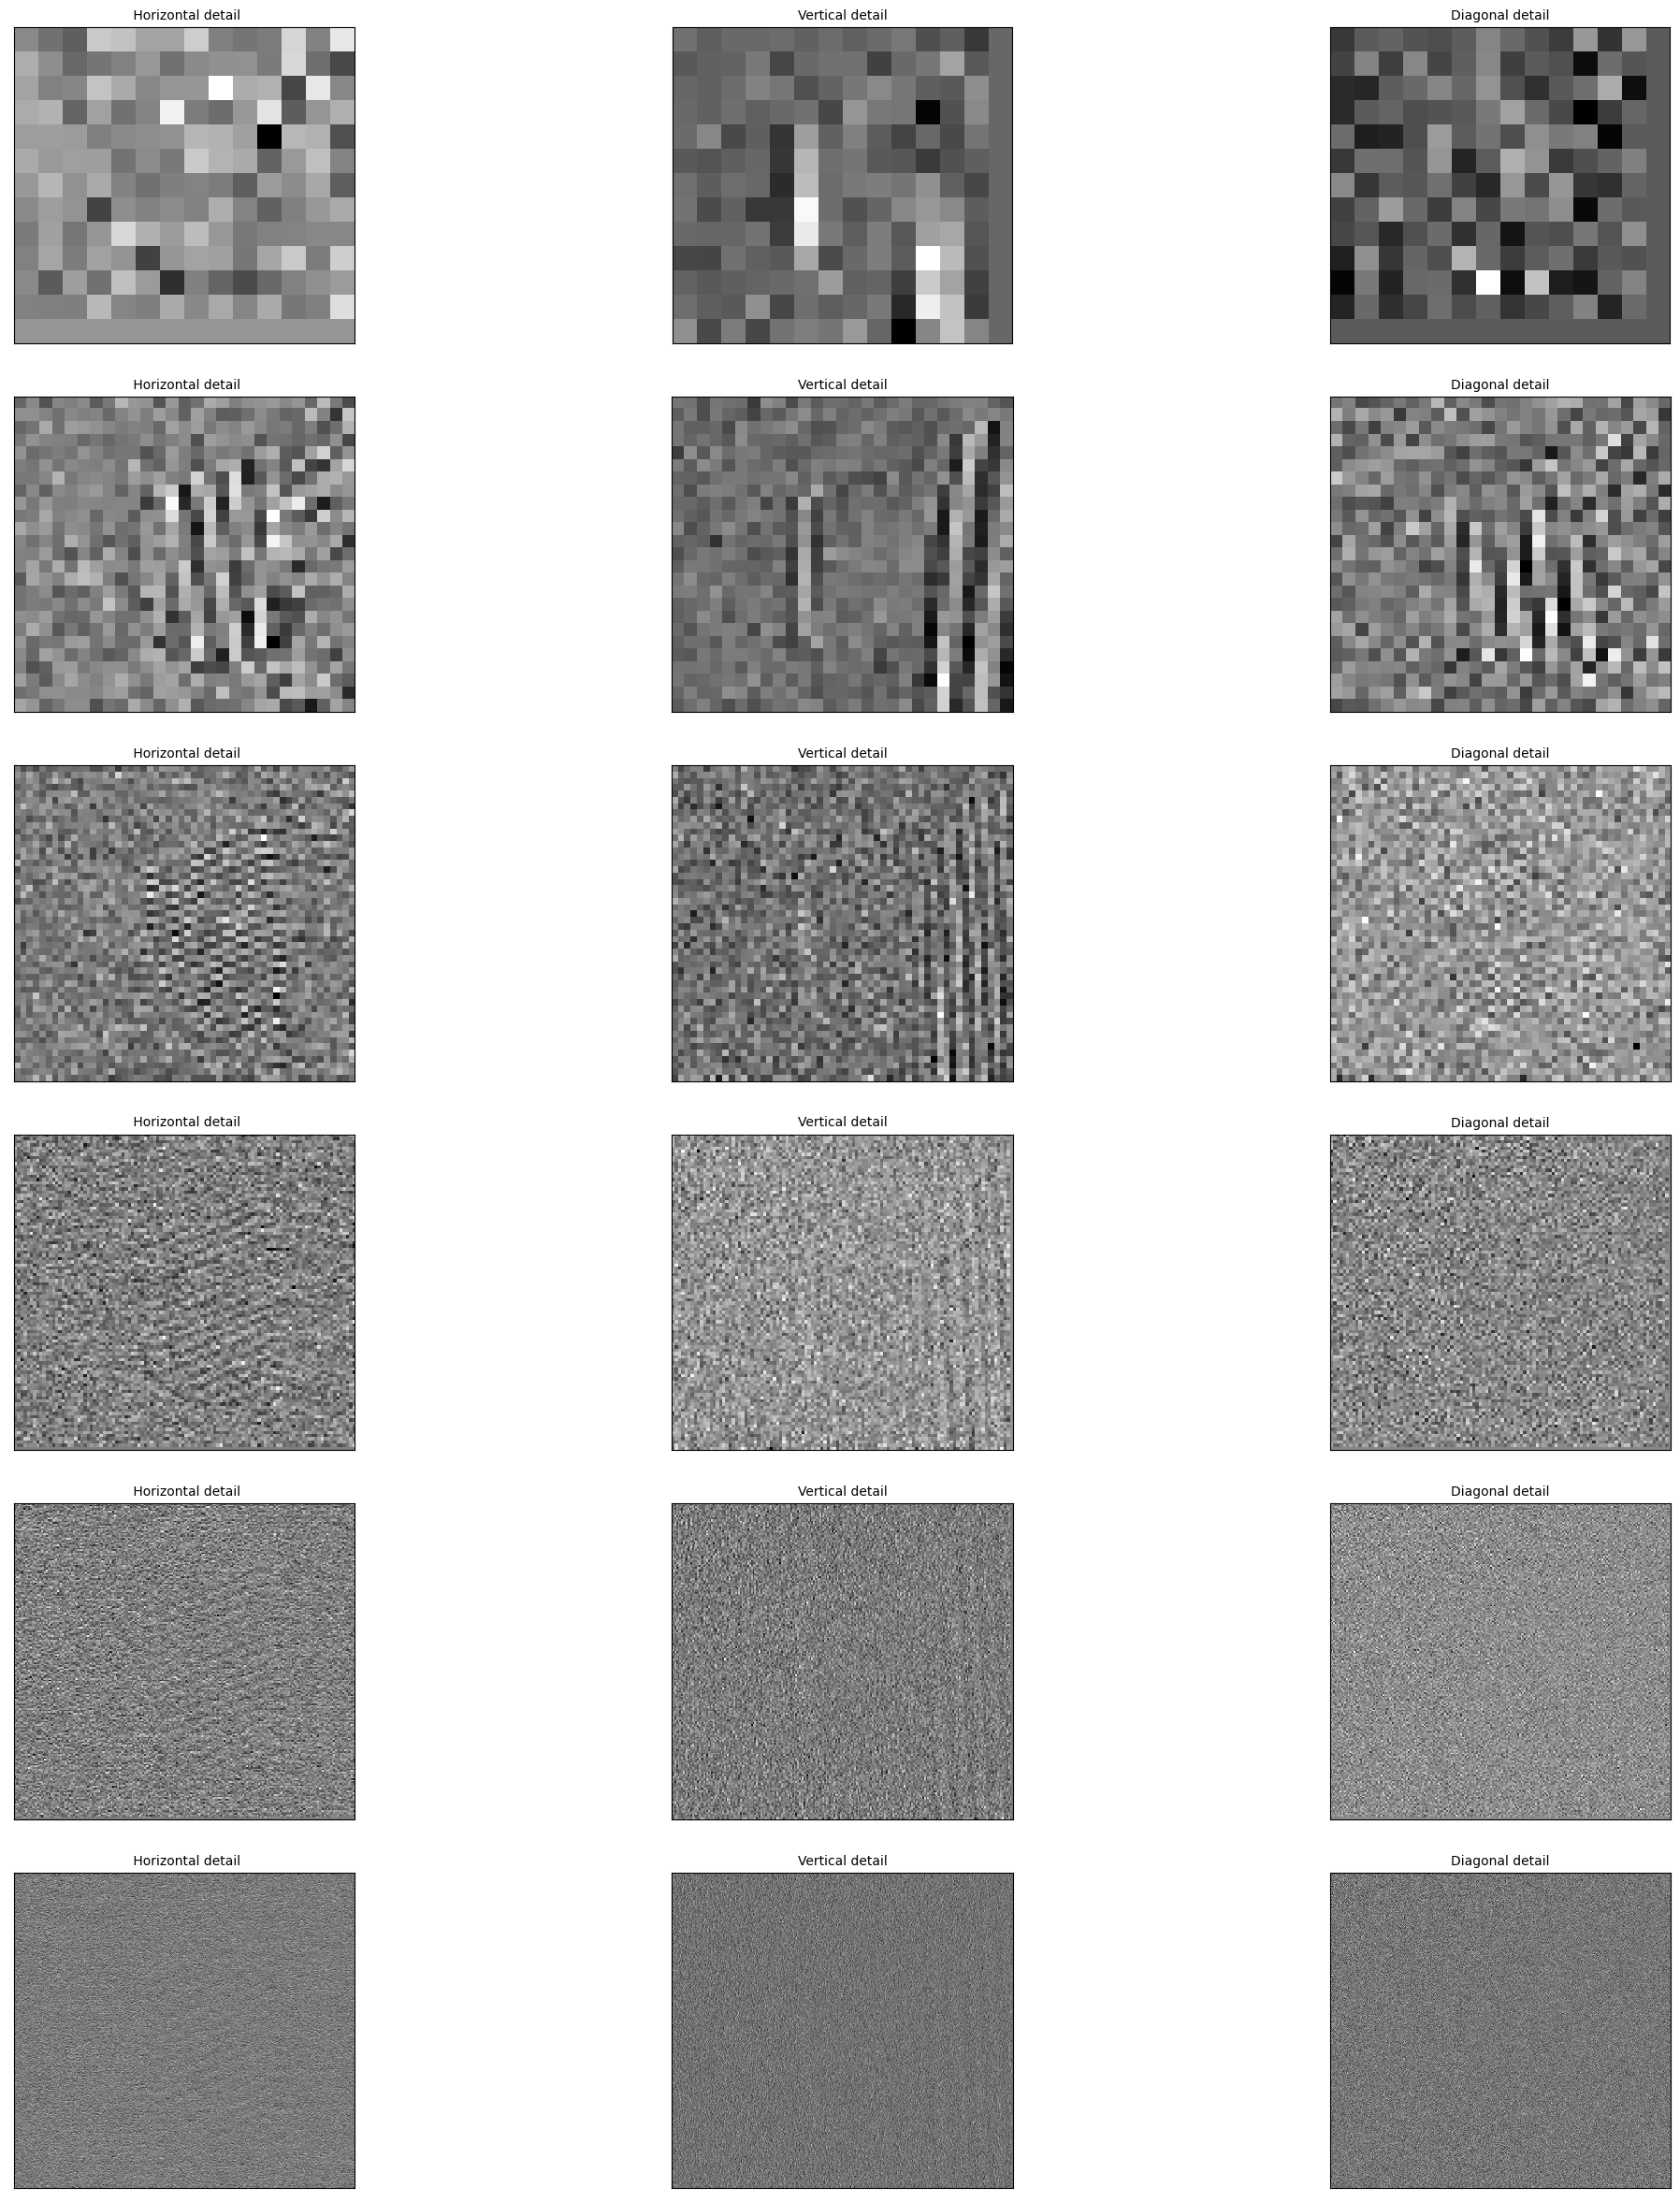

In [25]:
fig = plt.figure(figsize=(24, 24))
i=1
for c in C[1:]:
    for j, a in enumerate(c):
        ax = fig.add_subplot(levels, 3, i)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[j+1], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        i+=1

fig.tight_layout()
plt.show()

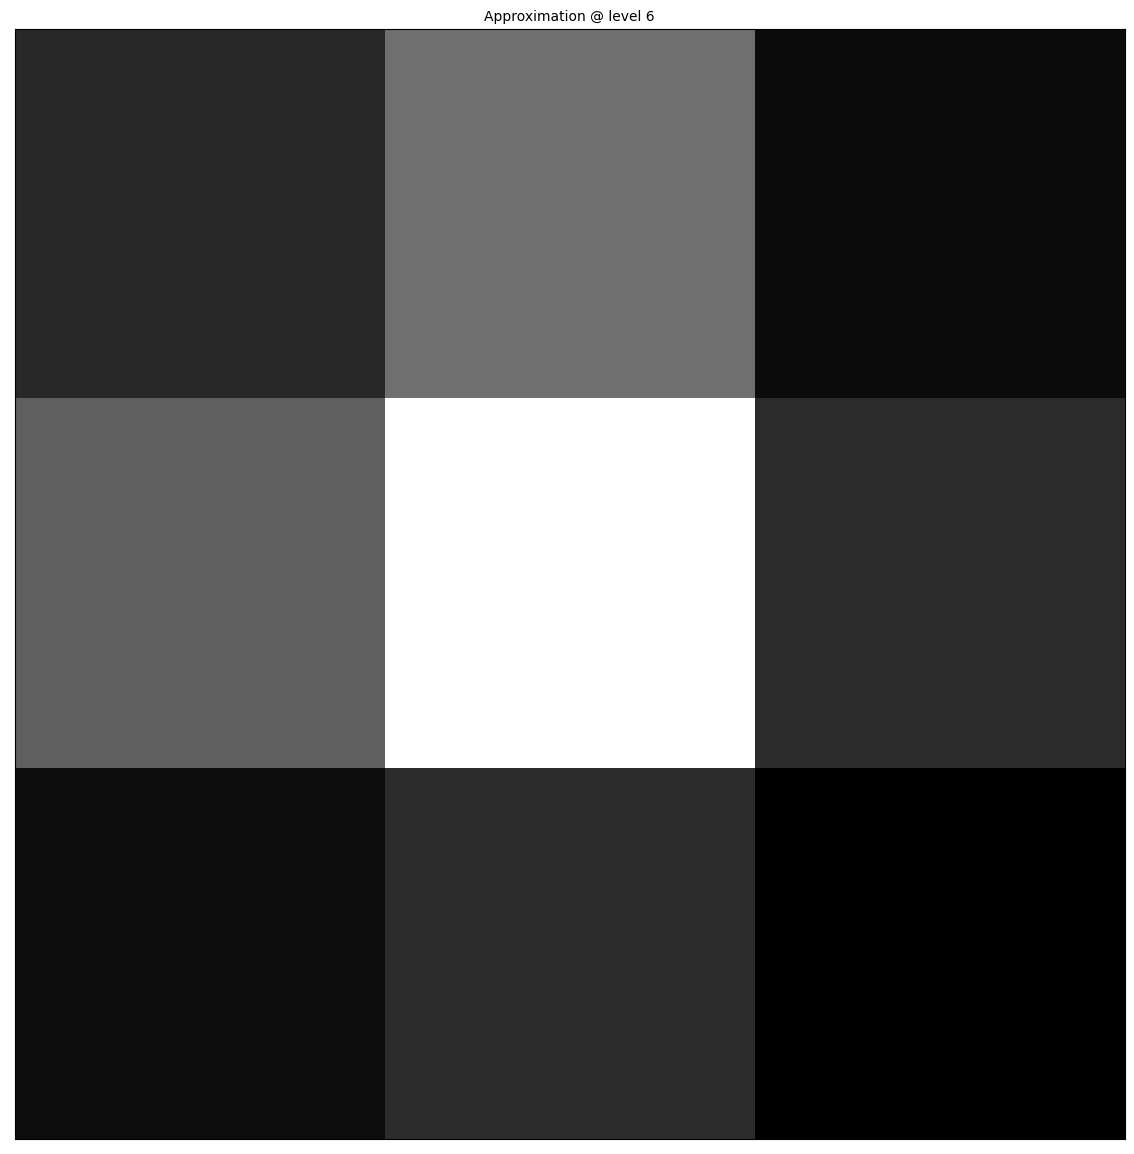

In [28]:
original2 = fft(img[0,:,:,0])

levels=6

C = pywt.wavedec2(original2, 'db1', mode='periodization',level=levels)

titles = ['Approximation @ level {}'.format(levels), ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']

cA2=C[0]
fig = plt.figure(figsize=(12, 12))
plt.imshow(cA2, interpolation="nearest", cmap=plt.cm.gray)
plt.title(titles[0], fontsize=10)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

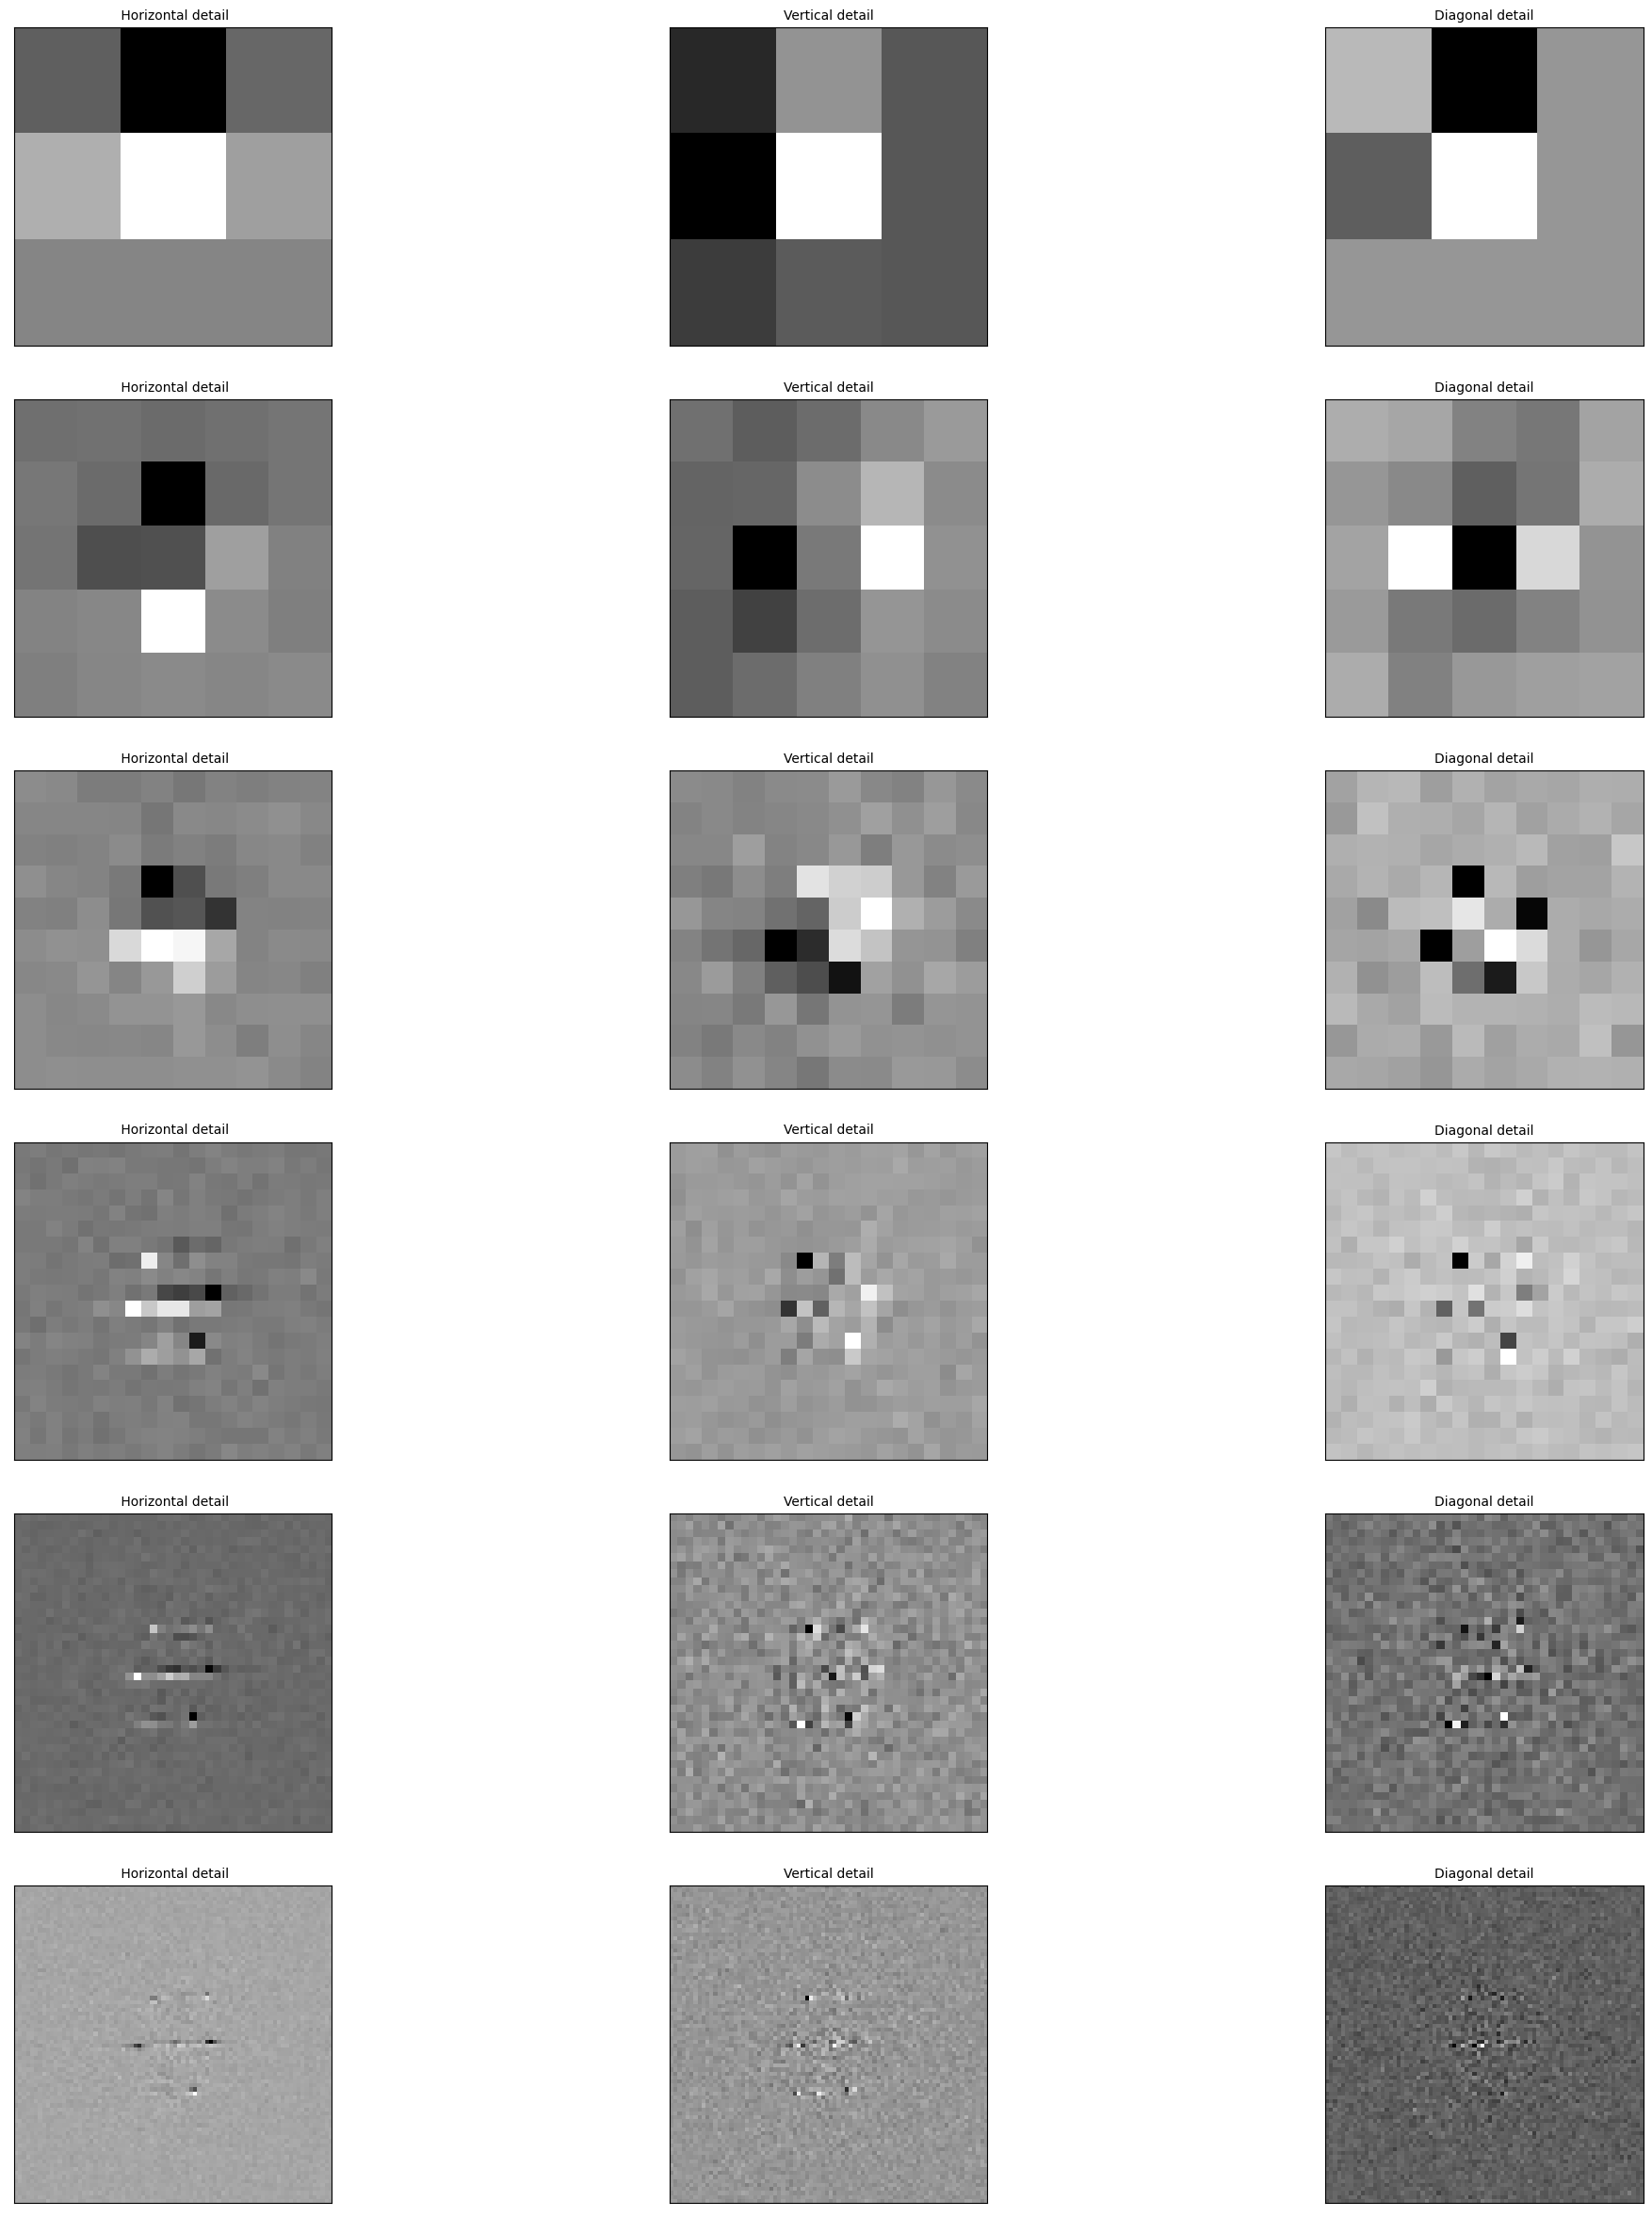

In [29]:
fig = plt.figure(figsize=(24, 24))
i=1
for c in C[1:]:
    for j, a in enumerate(c):
        ax = fig.add_subplot(levels, 3, i)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[j+1], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        i+=1

fig.tight_layout()
plt.show()